In [ ]:
!pip install scenedetect yt-dlp opencv-python-headless
!pip install pafy # Install the missing pafy module using pip.
!pip install youtube-dl # Install youtube-dl using pip
import cv2
import pafy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.3/127.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.7 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yt_dlp
import cv2
import os
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
import pandas as pd

def get_best_video_url(video_url):
    ydl_opts = {
        'quiet': True,
        'format': 'best[ext=mp4]/best',  # Get the best video format
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        # Get the URL of the best format
        if 'url' in info:
            return info['url']
        elif 'formats' in info:
            return info['formats'][0]['url']  # Pick the first format's URL
        else:
            raise KeyError("No suitable URL found in video info.")


# Detect keyframes and save them with timestamps
def process_video_stream_with_keyframes(video_url, output_folder):
    # Get the best streamable URL
    stream_url = get_best_video_url(video_url)

    # Create necessary folders
    os.makedirs(output_folder, exist_ok=True)
    keyframe_folder = os.path.join(output_folder, "keyframes")
    os.makedirs(keyframe_folder, exist_ok=True)

    # Open video stream
    cap = cv2.VideoCapture(stream_url)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video stream: {video_url}")

    print(f"Processing video stream from: {video_url}")

    # Initialize PySceneDetect managers
    video_manager = VideoManager([stream_url])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector())

    # Detect scenes
    video_manager.set_duration()
    video_manager.start()
    scene_manager.detect_scenes(video_manager)
    scenes = scene_manager.get_scene_list()

    keyframe_data = []
    for i, (start_time, end_time) in enumerate(scenes):
        mid_frame = (start_time.get_frames() + end_time.get_frames()) // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame)
        ret, frame = cap.read()
        if ret:
            keyframe_path = os.path.join(keyframe_folder, f"keyframe_{i:04d}.jpg")
            cv2.imwrite(keyframe_path, frame)
            timestamp = start_time.get_seconds()
            keyframe_data.append({"timestamp": timestamp, "keyframe_path": keyframe_path})

    # Release resources
    cap.release()
    video_manager.release()

    # Save keyframe metadata
    keyframe_df = pd.DataFrame(keyframe_data)
    metadata_path = os.path.join(output_folder, "keyframes_metadata.csv")
    keyframe_df.to_csv(metadata_path, index=False)
    print(f"Keyframe metadata saved to {metadata_path}")
    return keyframe_df

# Example usage
output_folder = "/content/drive/My Drive/VideoFramesWithKeyframes"
video_url = "https://www.youtube.com/watch?v=efGqe1j3RNk"
keyframe_metadata = process_video_stream_with_keyframes(video_url, output_folder)


ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 29.970 FPS, resolution: 640 x 360
INFO:pyscenedetect:Duration set, start: None, duration: None, end: None.
INFO:pyscenedetect:Detecting scenes...


Processing video stream from: https://www.youtube.com/watch?v=efGqe1j3RNk
Keyframe metadata saved to /content/drive/My Drive/VideoFramesWithKeyframes/keyframes_metadata.csv


##Step 2: Compute Embeddings for Each Frame

###We’ll use a pre-trained model (e.g., EfficientNetB0) to extract embeddings for each frame.

In [ ]:
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd

# Load pre-trained EfficientNetB0 model
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Function to compute embeddings
def compute_embedding(image_path, model):
    img = load_img(image_path, target_size=(224, 224))  # Resize to model's input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return model.predict(img_array).flatten()

# Directory containing frame images
frames_folder = "/content/drive/MyDrive/VideoFramesWithKeyframes/keyframes"
frame_files = sorted([os.path.join(frames_folder, fname) for fname in os.listdir(frames_folder) if fname.endswith(".jpg")])

# Compute embeddings for all frames
embeddings = []
for frame_file in frame_files:
    embedding = compute_embedding(frame_file, model)
    embeddings.append(embedding)

# Save embeddings to a CSV for future use
embeddings_df = pd.DataFrame(embeddings, index=frame_files)
embeddings_df.to_csv("/content/drive/MyDrive/VideoFramesWithKeyframes/keyframes/frame_embeddings.csv")
print("Embeddings saved to /content/drive/MyDrive/VideoFramesWithKeyFrames/frame_embeddings.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

###KNN for Frame Similarity

You can use KNN to find the closest frames to a given frame based on the embeddings you already have.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load embeddings
embeddings_df = pd.read_csv("/content/drive/MyDrive/VideoFramesWithKeyframes/keyframes/frame_embeddings.csv", index_col=0)
embeddings = embeddings_df.values

# Fit KNN model
knn = NearestNeighbors(n_neighbors=5, metric='cosine')  # Find 5 nearest neighbors using cosine similarity
knn.fit(embeddings)

# Query the KNN model for a specific frame
query_index = 45  # Index of the frame you want to find neighbors for
distances, indices = knn.kneighbors([embeddings[query_index]])

# Print neighbors
print(f"Frame {query_index} neighbors:")
for neighbor_index, distance in zip(indices[0], distances[0]):
    print(f"Neighbor: {neighbor_index}, Distance: {distance}")


Frame 45 neighbors:
Neighbor: 45, Distance: 0.0
Neighbor: 40, Distance: 0.5441602165080297
Neighbor: 37, Distance: 0.5899503194471434
Neighbor: 48, Distance: 0.5966073682072719
Neighbor: 17, Distance: 0.6192333295979014


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Generate pairs and labels based on embedding similarity
def create_labels_by_embedding_similarity(embeddings, threshold=0.4):
    pairs = []
    labels = []
    n = len(embeddings)

    for i in range(n):
        for j in range(i + 1, n):
            # Compute similarity
            similarity = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            # Assign label based on similarity threshold
            label = 1 if similarity >= threshold else 0
            pairs.append((i, j))
            labels.append(label)

    return pairs, labels

# Example usage
pairs, labels = create_labels_by_embedding_similarity(embeddings, threshold=0.8)
print(f"Generated {len(pairs)} pairs.")


Generated 4005 pairs.


In [ ]:
import pandas as pd

# Convert pairs and labels to DataFrame
pairs_df = pd.DataFrame(pairs, columns=["frame1_index", "frame2_index"])
pairs_df["label"] = labels

# Save to CSV
pairs_df.to_csv("/content/drive/MyDrive/VideoFramesWithKeyframes/pairs_with_labels_similarity.csv", index=False)
print("Pairs with labels saved to /content/drive/MyDrive/VideoFramesWithKeyframes/content/pairs_with_labels_similarity.csv")


Pairs with labels saved to /content/drive/MyDrive/VideoFramesWithKeyframes/content/pairs_with_labels_similarity.csv


In [ ]:
# Count positive and negative pairs
num_positive_pairs = pairs_df[pairs_df["label"] == 1].shape[0]
num_negative_pairs = pairs_df[pairs_df["label"] == 0].shape[0]

print(f"Number of positive pairs: {num_positive_pairs}")
print(f"Number of negative pairs: {num_negative_pairs}")


Number of positive pairs: 4
Number of negative pairs: 4001


In [ ]:
from sklearn.utils import resample

# Separate positive and negative pairs
positive_pairs = pairs_df[pairs_df["label"] == 1]
negative_pairs = pairs_df[pairs_df["label"] == 0]

# Upsample positive pairs
upsampled_positive_pairs = resample(
    positive_pairs,
    replace=True,  # Sample with replacement
    n_samples=len(negative_pairs),  # Match number of negative pairs
    random_state=42
)

# Combine upsampled positives and negatives
balanced_pairs = pd.concat([upsampled_positive_pairs, negative_pairs])

# Shuffle the dataset
balanced_pairs = balanced_pairs.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Balanced dataset size: {balanced_pairs.shape[0]}")


Balanced dataset size: 8002


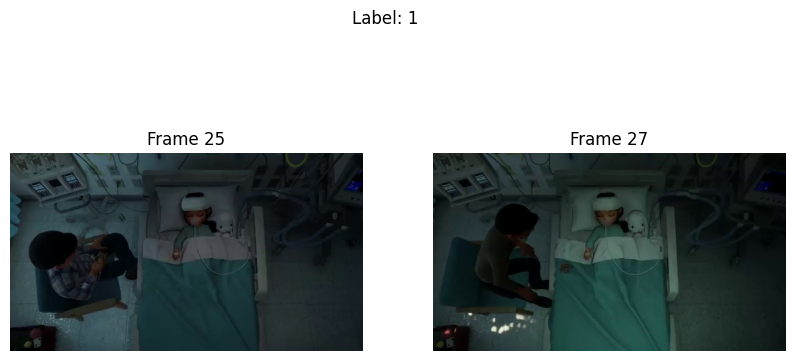

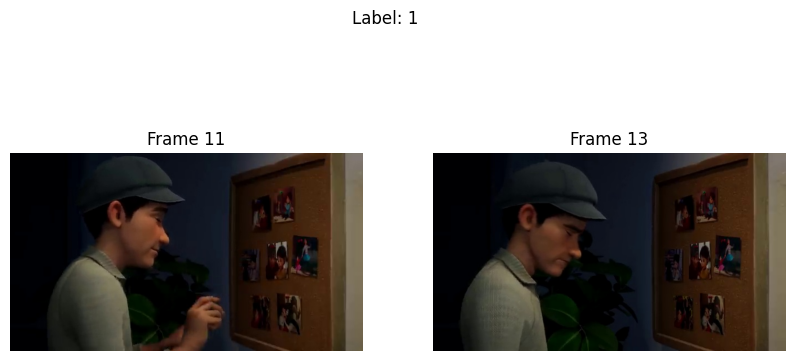

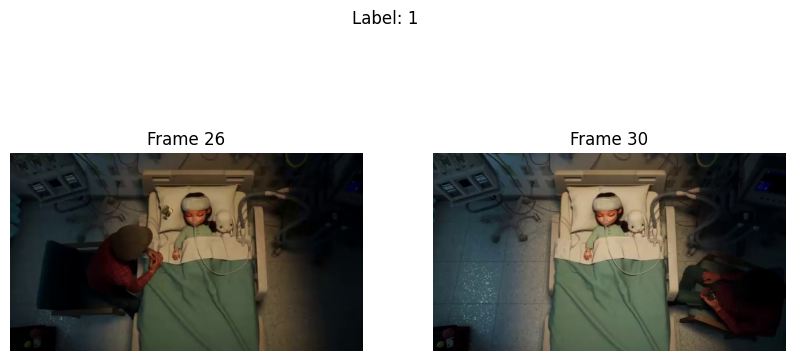

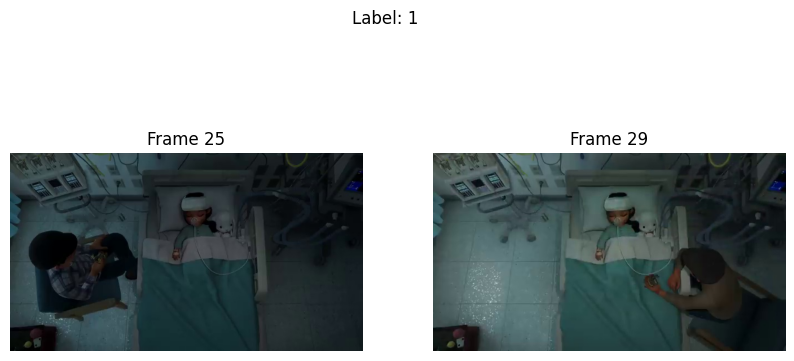

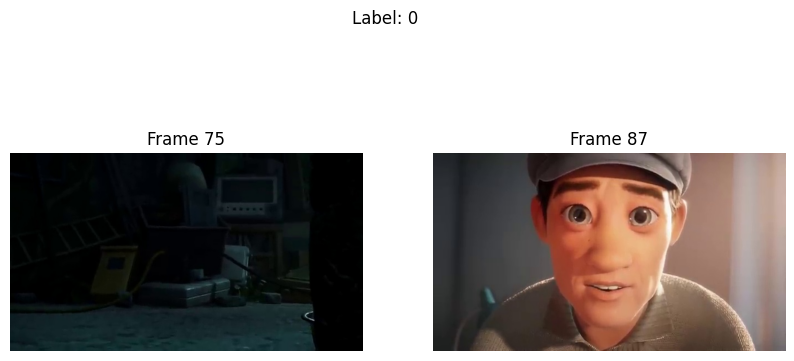

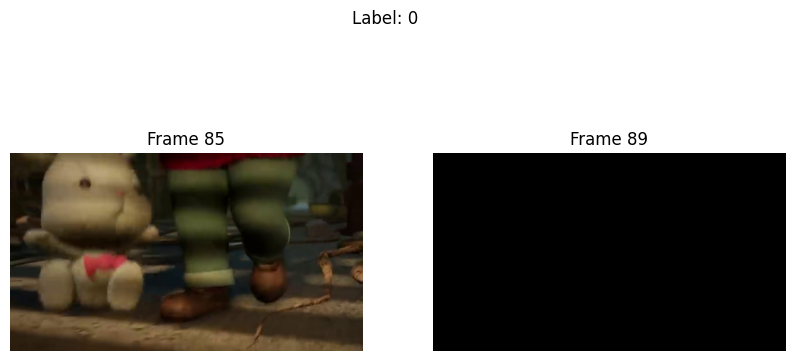

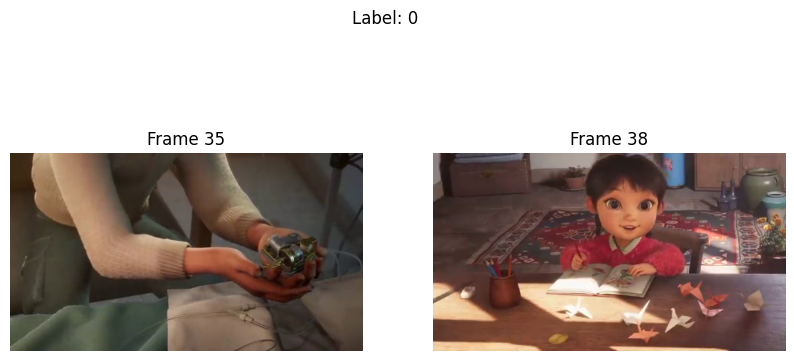

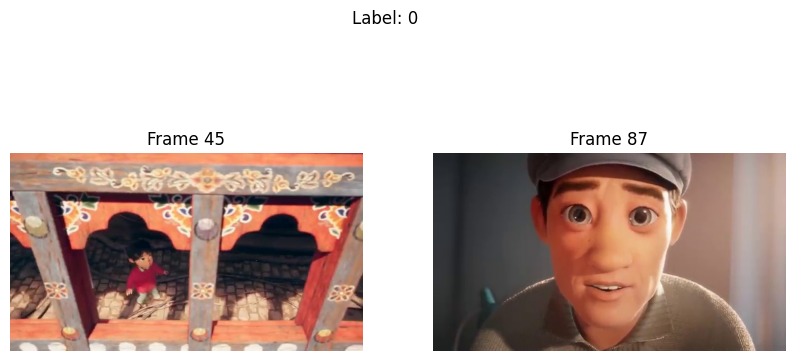

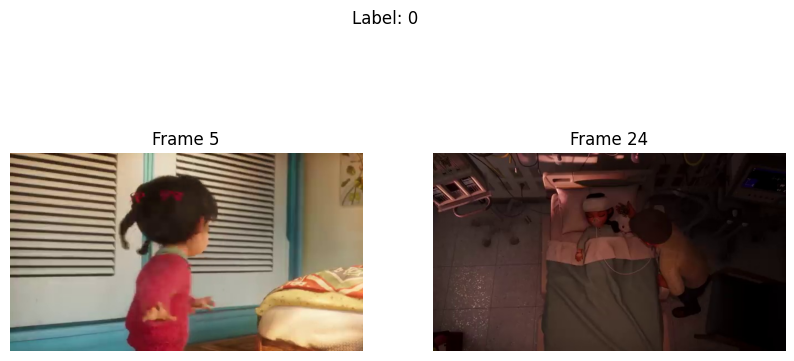

In [ ]:
def visualize_pairs(frame_files, pairs_df, num_samples=5):
    # Check available samples for positive and negative pairs
    positive_pairs = pairs_df[pairs_df["label"] == 1]
    negative_pairs = pairs_df[pairs_df["label"] == 0]

    num_positive_pairs = min(num_samples, positive_pairs.shape[0])
    num_negative_pairs = min(num_samples, negative_pairs.shape[0])

    positive_pairs = positive_pairs.sample(n=num_positive_pairs)
    negative_pairs = negative_pairs.sample(n=num_negative_pairs)

    def show_pair(pair, label):
        idx1, idx2 = pair["frame1_index"], pair["frame2_index"]
        img1 = cv2.imread(frame_files[idx1])
        img2 = cv2.imread(frame_files[idx2])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Label: {label}")
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(f"Frame {idx1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(f"Frame {idx2}")
        plt.axis("off")
        plt.show()

    # Display positive pairs
    for _, pair in positive_pairs.iterrows():
        show_pair(pair, label=1)

    # Display negative pairs
    for _, pair in negative_pairs.iterrows():
        show_pair(pair, label=0)

# Example usage
visualize_pairs(frame_files, pairs_df, num_samples=5)


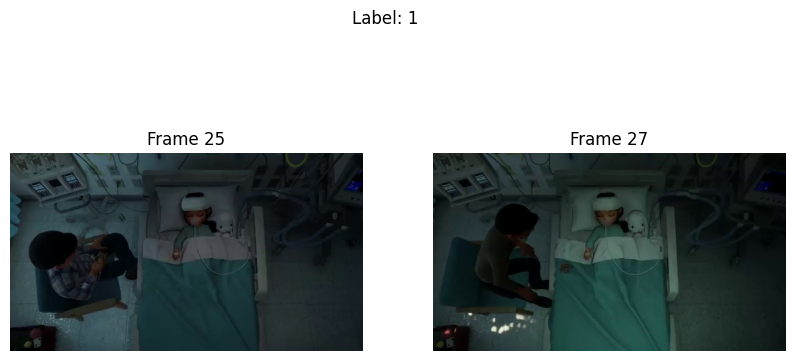

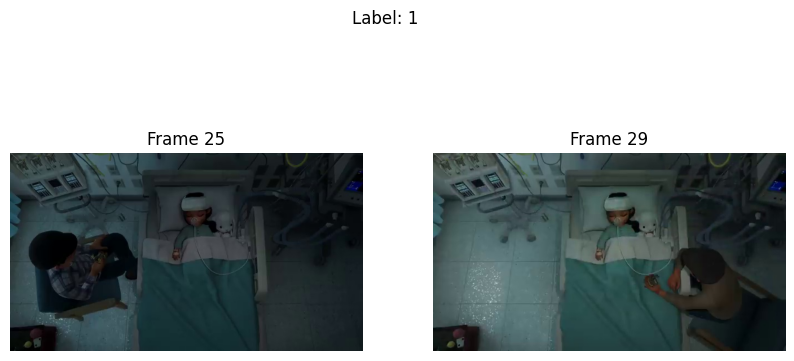

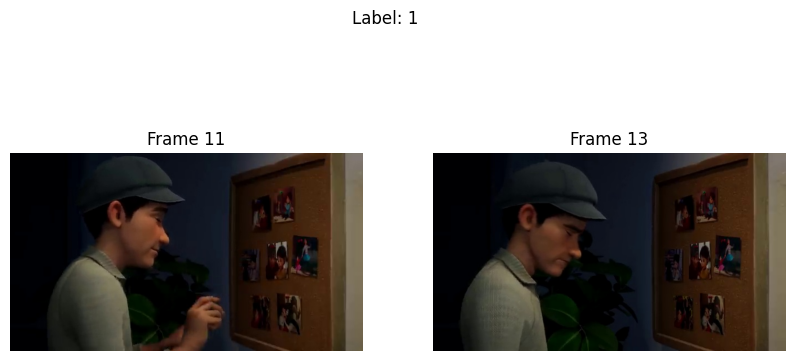

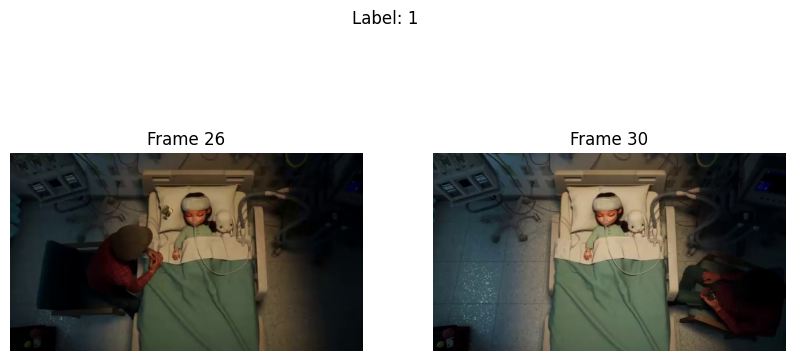

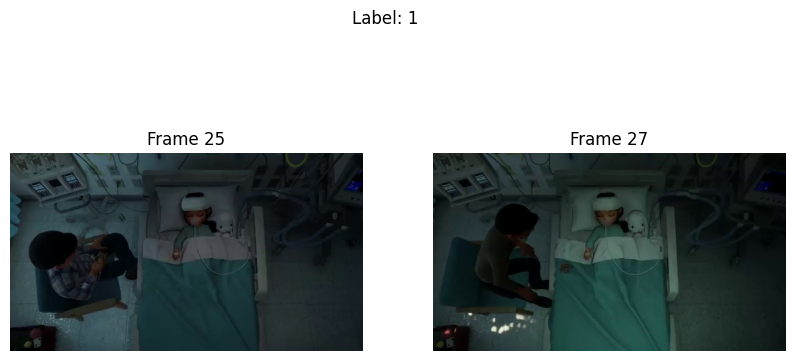

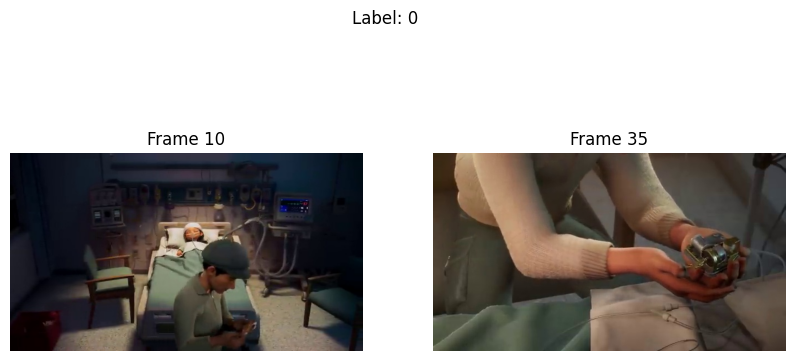

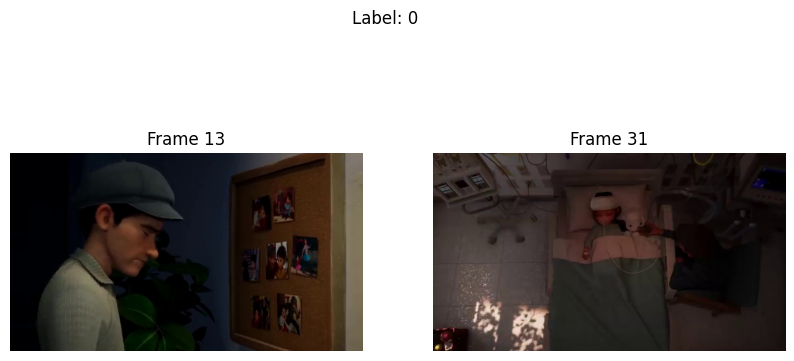

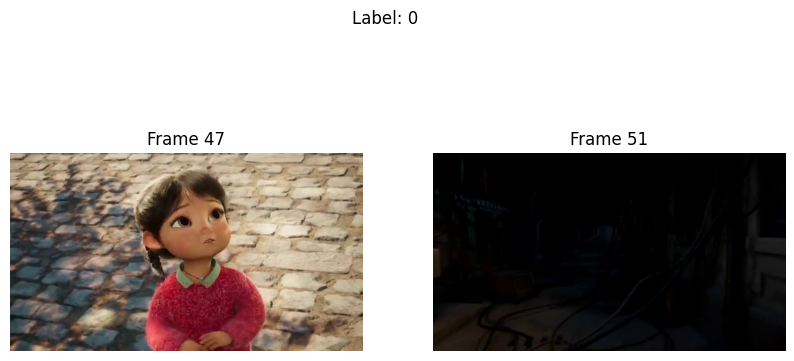

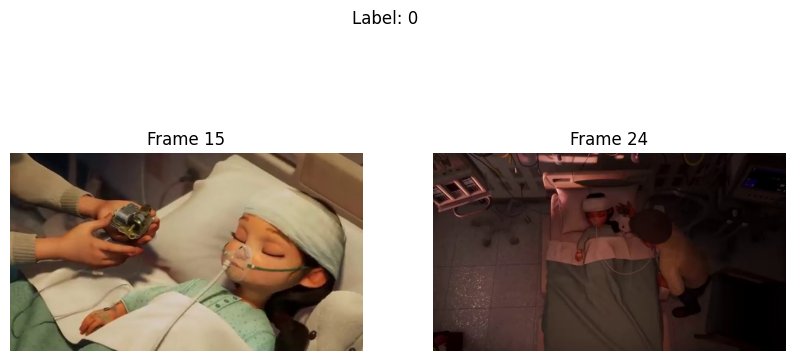

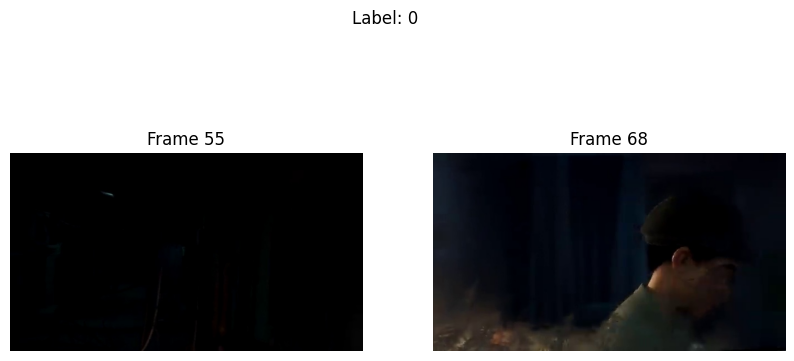

In [ ]:
# Visualize pairs from the balanced dataset
visualize_pairs(frame_files, balanced_pairs, num_samples=5)


In [ ]:
import yt_dlp
import cv2
import os

def get_best_video_url(video_url):
    ydl_opts = {
        'quiet': True,
        'format': 'best[ext=mp4]/best',  # Get the best video format
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        return info['url']  # URL to stream the video

def process_video_stream_with_frames(video_url, output_folder, save_interval=1):
    # Get the best video stream URL
    stream_url = get_best_video_url(video_url)

    # Open video stream
    cap = cv2.VideoCapture(stream_url)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video stream: {video_url}")

    # Create directories for frames and scenes
    frames_folder = os.path.join(output_folder, "frames")
    os.makedirs(frames_folder, exist_ok=True)

    scenes_folder = os.path.join(output_folder, "scenes")
    os.makedirs(scenes_folder, exist_ok=True)

    print(f"Processing video stream from: {video_url}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Total frames: {frame_count}, FPS: {fps}")

    scene_count = 0
    frame_index = 0
    prev_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save consecutive frames based on interval
        if frame_index % save_interval == 0:
            frame_path = os.path.join(frames_folder, f"frame_{frame_index:04d}.jpg")
            cv2.imwrite(frame_path, frame)

        # Detect scene changes
        if prev_frame is not None:
            diff = cv2.absdiff(frame, prev_frame)
            diff_score = diff.mean()
            if diff_score > 50:  # Threshold for scene change
                scene_count += 1
                scene_path = os.path.join(scenes_folder, f"scene_{scene_count:03d}.jpg")
                cv2.imwrite(scene_path, frame)
                print(f"Scene {scene_count} detected. Saved to {scene_path}")

        prev_frame = frame
        frame_index += 1

    cap.release()
    print(f"Finished processing. Total frames saved: {frame_index}. Total scenes detected: {scene_count}")

# Example usage
output_dir = "/content/drive/My Drive/VideoFramesWithConsecutiveFrames2"
os.makedirs(output_dir, exist_ok=True)

process_video_stream_with_frames(
    "https://www.youtube.com/watch?v=efGqe1j3RNk",
    output_dir,
    save_interval=1  # Save every frame
)


Processing video stream from: https://www.youtube.com/watch?v=efGqe1j3RNk
Total frames: 17832, FPS: 29.97002997002997
Scene 1 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_001.jpg
Scene 2 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_002.jpg
Scene 3 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_003.jpg
Scene 4 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_004.jpg
Scene 5 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_005.jpg
Scene 6 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_006.jpg
Scene 7 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_007.jpg
Scene 8 detected. Saved to /content/drive/My Drive/VideoFramesWithConsecutiveFrames2/scenes/scene_008.jpg
Scene 9 detected. Saved to /conten

In [ ]:
import os

# List all frame files in the directory
frame_files = sorted([
    os.path.join("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/frames", fname)
    for fname in os.listdir("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/frames")
    if fname.endswith(".jpg")
])

# Downsample the frames
def downsample_frames(frame_files, step=5):
    # Keep every Nth frame
    return frame_files[::step]

# Downsample
downsampled_frames = downsample_frames(frame_files, step=5)

# Print results
print(f"Reduced frames from {len(frame_files)} to {len(downsampled_frames)}.")


Reduced frames from 17832 to 3567.


In [ ]:
import cv2
import numpy as np
import os

# Define the folder containing the middle frame images from each scene
scene_folder = '/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/frames'

# Create a folder for saving flow images
flow_folder = '/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images'
os.makedirs(flow_folder, exist_ok=True)

# Function to compute dense optical flow between two consecutive frames
def compute_optical_flow(image1_path, image2_path):
    # Read the images in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the images are the same size (resize if necessary)
    img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))

    # Compute optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to visualize and save optical flow
def visualize_optical_flow(flow, save_path):
    # Compute magnitude and angle of flow vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Normalize magnitude to a 0-255 range
    mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to 8-bit image
    mag = np.uint8(mag)

    # Create a color representation (optional)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Angle in degrees
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Magnitude as value

    # Convert HSV to RGB
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Save the flow visualization as a JPG file
    cv2.imwrite(save_path, rgb_flow)

# Get list of scene images (middle frames) sorted by scene number
scene_images = sorted([f for f in os.listdir(scene_folder) if f.endswith('.jpg')])

# Compute and save optical flow images between consecutive frames
for i in range(len(scene_images) - 1):
    image1_path = os.path.join(scene_folder, scene_images[i])
    image2_path = os.path.join(scene_folder, scene_images[i + 1])

    # Compute optical flow
    flow = compute_optical_flow(image1_path, image2_path)

    # Extract the scene numbers from filenames
    scene_number1 = scene_images[i].split('_')[1]
    scene_number2 = scene_images[i + 1].split('_')[1]

    # Save the optical flow with scene numbers in the filename
    flow_image_path = os.path.join(flow_folder, f"flow_{scene_number1}_to_{scene_number2}.jpg")
    visualize_optical_flow(flow, save_path=flow_image_path)
    print(f"Saved: {flow_image_path}")


Streaming output truncated to the last 5000 lines.
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_4999.jpg_to_5000.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5000.jpg_to_5001.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5001.jpg_to_5002.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5002.jpg_to_5003.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5003.jpg_to_5004.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5004.jpg_to_5005.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5005.jpg_to_5006.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5006.jpg_to_5007.jpg.jpg
Saved: /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images/flow_5007.jpg_to_5008.jpg

In [ ]:
import cv2
import numpy as np
import os
from scipy.spatial.distance import euclidean

def extract_flow_features(flow_image_path):
    # Read the flow image
    flow_img = cv2.imread(flow_image_path)

    if flow_img is None:
        print(f"Error: Unable to load {flow_image_path}")
        return None

    # Convert to grayscale to analyze motion intensity
    gray_flow = cv2.cvtColor(flow_img, cv2.COLOR_BGR2GRAY)

    # Compute the mean motion intensity (magnitude)
    mean_mag = np.mean(gray_flow)

    return mean_mag

# Path to the flow images
flow_folder = '/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/flow_images'

# List all flow images sorted by filename
flow_images = sorted([os.path.join(flow_folder, f) for f in os.listdir(flow_folder) if f.endswith('.jpg')])

# Extract features for all flow images
flow_features = []
for flow_image in flow_images:
    mag = extract_flow_features(flow_image)
    flow_features.append((flow_image, mag))

print(f"Extracted features for {len(flow_features)} flow images.")


Extracted features for 17831 flow images.


In [ ]:
def create_labels_from_flow_features(flow_features, threshold=10.0):
    pairs = []
    labels = []

    for i in range(len(flow_features) - 1):
        mag1 = flow_features[i][1]
        mag2 = flow_features[i + 1][1]

        # Compute the difference in magnitudes
        diff = abs(mag1 - mag2)

        # Assign labels based on the threshold
        label = 1 if diff < threshold else 0
        pairs.append((flow_features[i][0], flow_features[i + 1][0]))
        labels.append(label)

    return pairs, labels

# Create labeled data
pairs, labels = create_labels_from_flow_features(flow_features, threshold=10.0)
print(f"Generated {len(pairs)} labeled pairs.")
import pandas as pd

# Save labeled data to a CSV file
labeled_data = pd.DataFrame(pairs, columns=["Flow_Image1", "Flow_Image2"])
labeled_data["Label"] = labels
labeled_data.to_csv('/content/flow_image_labeled_data.csv', index=False)

print("Labeled data saved to /content/flow_image_labeled_data.csv")


Generated 17830 labeled pairs.
Labeled data saved to /content/flow_image_labeled_data.csv


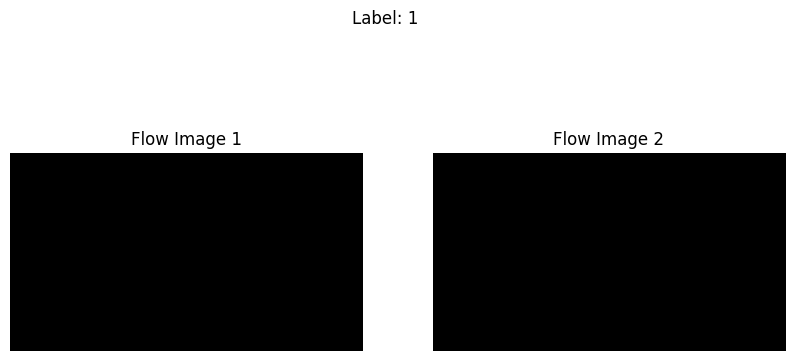

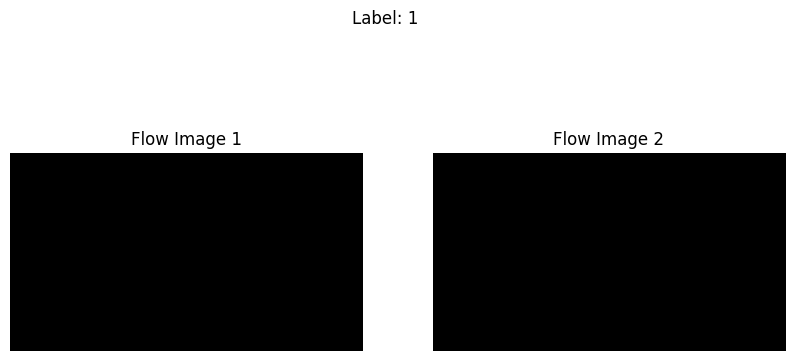

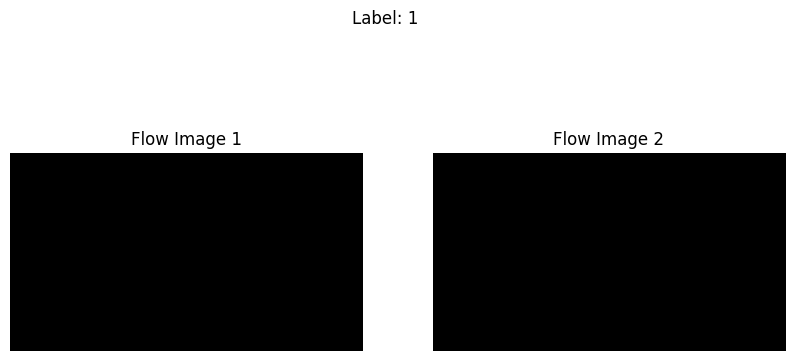

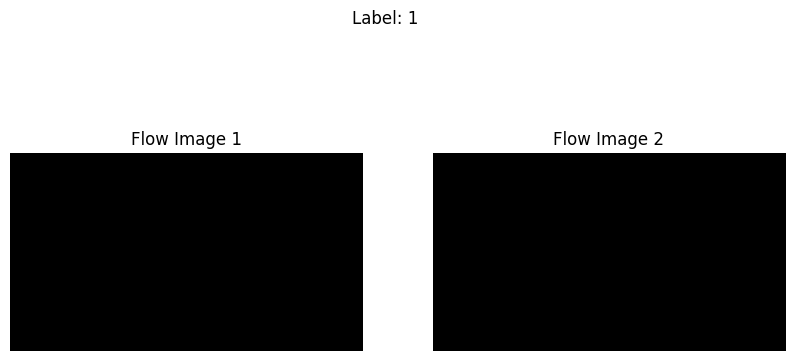

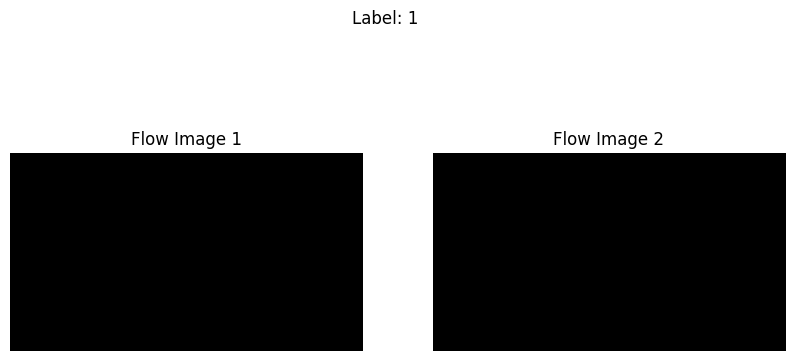

In [ ]:
import matplotlib.pyplot as plt

def visualize_labeled_pairs(pairs, labels, num_samples=5):
    for i in range(min(num_samples, len(pairs))):
        flow1_path = pairs[i][0]
        flow2_path = pairs[i][1]
        label = labels[i]

        # Load flow images
        flow1 = cv2.imread(flow1_path)
        flow2 = cv2.imread(flow2_path)

        if flow1 is None or flow2 is None:
            print(f"Error: Unable to load images: {flow1_path}, {flow2_path}")
            continue

        # Convert to RGB for visualization
        flow1 = cv2.cvtColor(flow1, cv2.COLOR_BGR2RGB)
        flow2 = cv2.cvtColor(flow2, cv2.COLOR_BGR2RGB)

        # Plot the flow images
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Label: {label}")

        plt.subplot(1, 2, 1)
        plt.imshow(flow1)
        plt.title("Flow Image 1")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(flow2)
        plt.title("Flow Image 2")
        plt.axis("off")
        plt.show()

# Visualize labeled pairs
visualize_labeled_pairs(pairs, labels, num_samples=5)